In [36]:
from env import *
from runEnv import UAVEnv

In [37]:
# 设置数据目录
uav_csv = "data/uav.csv"
task_csv = "data/task.csv"
# 加载不同规模的无人机、任务和目标数据
# uavs, tasks, targets = load_different_scale_csv(uav_csv, task_csv, 5) # 小规模数据
# uavs, tasks, targets = load_different_scale_csv(uav_csv, task_csv, 10) # 中规模数据
uavs, tasks, targets = load_different_scale_csv(uav_csv, task_csv, 20) # 大规模数据

# 俩个模式：DQN和Attention
dqn_mode = "dqn"
my_dqn_mode = "my_dqn"
attention_mode = "attention"
env = UAVEnv(uavs, targets, tasks, mode=my_dqn_mode)

In [38]:
"""
运行 DQN 优化
"""
# from train.dqn_train import train_dqn
# model = train_dqn(env)

'\n运行 DQN 优化\n'

Episode 0 | Total Reward: 0.88 | Total Fitness: 0.91 | Total Distance: 2602.42 | Total Time: 1507.01 | Total Success : 0.92 | Epsilon: 0.995


d:\code\python_project\mywork\my\train\dqn_train.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  s2 = torch.tensor(s2, dtype=torch.float32)


Episode 1 | Total Reward: 0.88 | Total Fitness: 0.89 | Total Distance: 2626.45 | Total Time: 1548.25 | Total Success : 0.92 | Epsilon: 0.990
Episode 2 | Total Reward: 0.87 | Total Fitness: 0.86 | Total Distance: 2682.38 | Total Time: 1504.28 | Total Success : 0.92 | Epsilon: 0.985
Episode 3 | Total Reward: 0.92 | Total Fitness: 0.93 | Total Distance: 2650.40 | Total Time: 1540.66 | Total Success : 0.97 | Epsilon: 0.980
Episode 4 | Total Reward: 0.91 | Total Fitness: 0.92 | Total Distance: 2615.32 | Total Time: 1514.20 | Total Success : 0.95 | Epsilon: 0.975
Episode 5 | Total Reward: 0.89 | Total Fitness: 0.90 | Total Distance: 2590.35 | Total Time: 1602.49 | Total Success : 0.93 | Epsilon: 0.970
Episode 6 | Total Reward: 0.79 | Total Fitness: 0.81 | Total Distance: 2529.45 | Total Time: 1583.04 | Total Success : 0.83 | Epsilon: 0.966
Episode 7 | Total Reward: 0.83 | Total Fitness: 0.86 | Total Distance: 2672.21 | Total Time: 1567.91 | Total Success : 0.88 | Epsilon: 0.961
Episode 8 | T

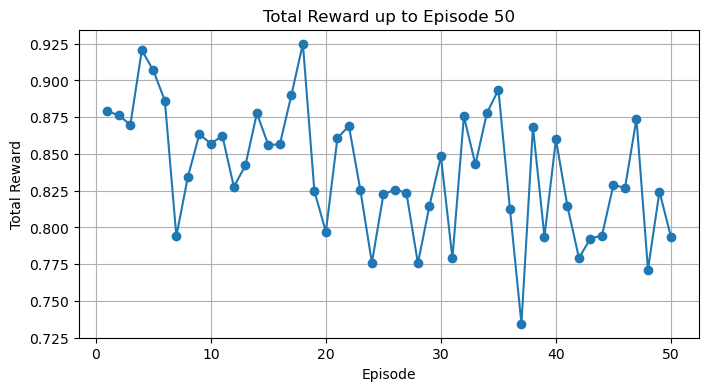

Episode 50 | Total Reward: 0.80 | Total Fitness: 0.87 | Total Distance: 2669.04 | Total Time: 1533.20 | Total Success : 0.83 | Epsilon: 0.774
Episode 51 | Total Reward: 0.84 | Total Fitness: 0.89 | Total Distance: 2655.55 | Total Time: 1555.35 | Total Success : 0.88 | Epsilon: 0.771
Episode 52 | Total Reward: 0.81 | Total Fitness: 0.89 | Total Distance: 2655.61 | Total Time: 1567.96 | Total Success : 0.85 | Epsilon: 0.767
Episode 53 | Total Reward: 0.80 | Total Fitness: 0.88 | Total Distance: 2639.37 | Total Time: 1514.55 | Total Success : 0.83 | Epsilon: 0.763
Episode 54 | Total Reward: 0.86 | Total Fitness: 0.95 | Total Distance: 2398.21 | Total Time: 1531.07 | Total Success : 0.90 | Epsilon: 0.759
Episode 55 | Total Reward: 0.80 | Total Fitness: 0.90 | Total Distance: 2532.33 | Total Time: 1580.63 | Total Success : 0.83 | Epsilon: 0.755
Episode 56 | Total Reward: 0.84 | Total Fitness: 0.89 | Total Distance: 2541.90 | Total Time: 1584.72 | Total Success : 0.88 | Epsilon: 0.751
Episod

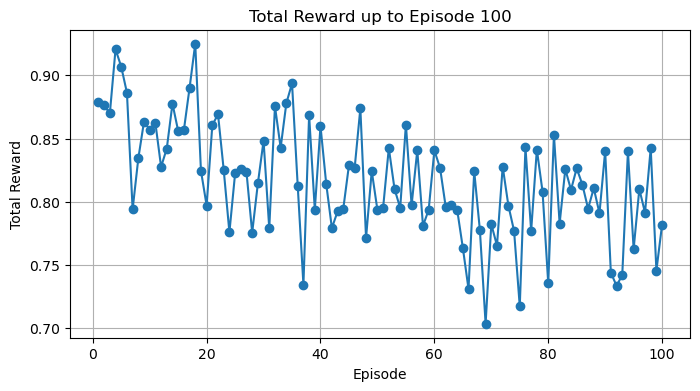

Episode 100 | Total Reward: 0.87 | Total Fitness: 0.92 | Total Distance: 2563.98 | Total Time: 1522.64 | Total Success : 0.88 | Epsilon: 0.603
Episode 101 | Total Reward: 0.83 | Total Fitness: 0.88 | Total Distance: 2591.23 | Total Time: 1550.84 | Total Success : 0.85 | Epsilon: 0.600
Episode 102 | Total Reward: 0.84 | Total Fitness: 0.92 | Total Distance: 2521.57 | Total Time: 1461.14 | Total Success : 0.85 | Epsilon: 0.597
Episode 103 | Total Reward: 0.80 | Total Fitness: 0.87 | Total Distance: 2621.60 | Total Time: 1556.14 | Total Success : 0.82 | Epsilon: 0.594
Episode 104 | Total Reward: 0.78 | Total Fitness: 0.92 | Total Distance: 2639.43 | Total Time: 1550.23 | Total Success : 0.80 | Epsilon: 0.591
Episode 105 | Total Reward: 0.85 | Total Fitness: 0.90 | Total Distance: 2641.10 | Total Time: 1604.54 | Total Success : 0.87 | Epsilon: 0.588
Episode 106 | Total Reward: 0.82 | Total Fitness: 0.92 | Total Distance: 2676.99 | Total Time: 1635.00 | Total Success : 0.83 | Epsilon: 0.585

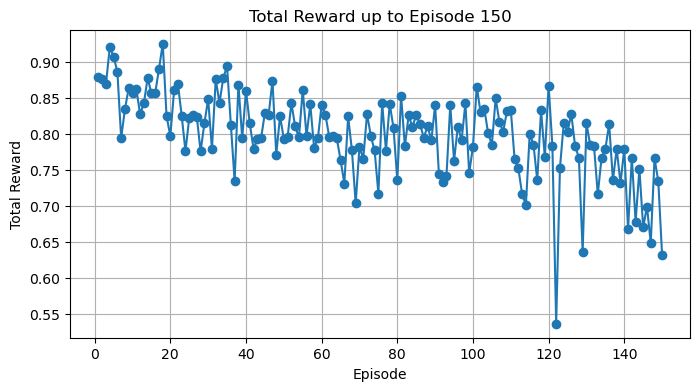

Episode 150 | Total Reward: 0.70 | Total Fitness: 0.86 | Total Distance: 2723.94 | Total Time: 1636.96 | Total Success : 0.72 | Epsilon: 0.469
Episode 151 | Total Reward: 0.62 | Total Fitness: 0.85 | Total Distance: 2634.93 | Total Time: 1697.24 | Total Success : 0.63 | Epsilon: 0.467
Episode 152 | Total Reward: 0.78 | Total Fitness: 0.90 | Total Distance: 2635.39 | Total Time: 1726.93 | Total Success : 0.80 | Epsilon: 0.464
Episode 153 | Total Reward: 0.78 | Total Fitness: 0.83 | Total Distance: 2712.27 | Total Time: 1513.02 | Total Success : 0.80 | Epsilon: 0.462
Episode 154 | Total Reward: 0.70 | Total Fitness: 0.84 | Total Distance: 2467.55 | Total Time: 1653.80 | Total Success : 0.72 | Epsilon: 0.460
Episode 155 | Total Reward: 0.75 | Total Fitness: 0.91 | Total Distance: 2513.70 | Total Time: 1504.22 | Total Success : 0.77 | Epsilon: 0.458
Episode 156 | Total Reward: 0.68 | Total Fitness: 0.77 | Total Distance: 2688.58 | Total Time: 1574.47 | Total Success : 0.70 | Epsilon: 0.455

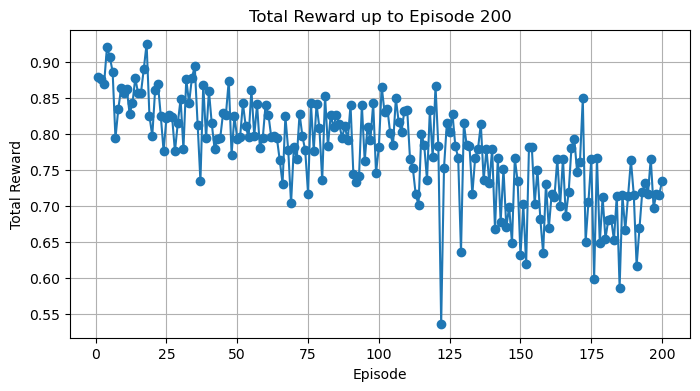

Episode 200 | Total Reward: 0.65 | Total Fitness: 0.82 | Total Distance: 2794.56 | Total Time: 1658.85 | Total Success : 0.68 | Epsilon: 0.365
Episode 201 | Total Reward: 0.64 | Total Fitness: 0.80 | Total Distance: 2419.20 | Total Time: 1469.99 | Total Success : 0.67 | Epsilon: 0.363
Episode 202 | Total Reward: 0.57 | Total Fitness: 0.76 | Total Distance: 2902.23 | Total Time: 1754.54 | Total Success : 0.60 | Epsilon: 0.361
Episode 203 | Total Reward: 0.73 | Total Fitness: 0.85 | Total Distance: 2790.95 | Total Time: 1637.95 | Total Success : 0.77 | Epsilon: 0.360
Episode 204 | Total Reward: 0.67 | Total Fitness: 0.91 | Total Distance: 2759.93 | Total Time: 1689.83 | Total Success : 0.70 | Epsilon: 0.358
Episode 205 | Total Reward: 0.69 | Total Fitness: 0.81 | Total Distance: 2572.63 | Total Time: 1648.37 | Total Success : 0.72 | Epsilon: 0.356
Episode 206 | Total Reward: 0.71 | Total Fitness: 0.83 | Total Distance: 2770.20 | Total Time: 1556.44 | Total Success : 0.75 | Epsilon: 0.354

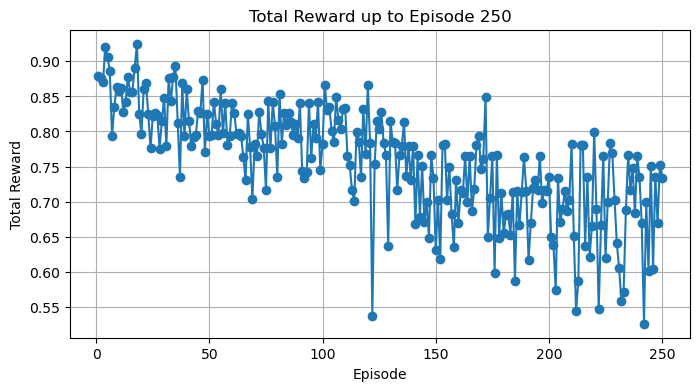

Episode 250 | Total Reward: 0.74 | Total Fitness: 0.86 | Total Distance: 2639.23 | Total Time: 1607.98 | Total Success : 0.77 | Epsilon: 0.284
Episode 251 | Total Reward: 0.48 | Total Fitness: 0.78 | Total Distance: 2370.34 | Total Time: 1477.05 | Total Success : 0.50 | Epsilon: 0.283
Episode 252 | Total Reward: 0.62 | Total Fitness: 0.83 | Total Distance: 2584.77 | Total Time: 1547.99 | Total Success : 0.65 | Epsilon: 0.281
Episode 253 | Total Reward: 0.64 | Total Fitness: 0.87 | Total Distance: 2624.17 | Total Time: 1742.53 | Total Success : 0.67 | Epsilon: 0.280
Episode 254 | Total Reward: 0.70 | Total Fitness: 0.86 | Total Distance: 2805.40 | Total Time: 1608.67 | Total Success : 0.73 | Epsilon: 0.279
Episode 255 | Total Reward: 0.65 | Total Fitness: 0.90 | Total Distance: 2650.11 | Total Time: 1610.91 | Total Success : 0.68 | Epsilon: 0.277
Episode 256 | Total Reward: 0.76 | Total Fitness: 0.88 | Total Distance: 2492.39 | Total Time: 1611.19 | Total Success : 0.78 | Epsilon: 0.276

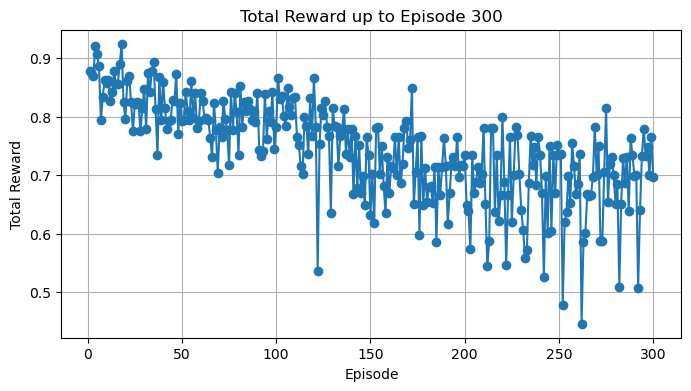

Episode 300 | Total Reward: 0.74 | Total Fitness: 0.94 | Total Distance: 2530.98 | Total Time: 1561.44 | Total Success : 0.77 | Epsilon: 0.221
Episode 301 | Total Reward: 0.56 | Total Fitness: 0.73 | Total Distance: 2549.75 | Total Time: 1844.23 | Total Success : 0.58 | Epsilon: 0.220
Episode 302 | Total Reward: 0.65 | Total Fitness: 0.86 | Total Distance: 2696.30 | Total Time: 1814.22 | Total Success : 0.68 | Epsilon: 0.219
Episode 303 | Total Reward: 0.75 | Total Fitness: 0.93 | Total Distance: 2651.34 | Total Time: 1589.05 | Total Success : 0.78 | Epsilon: 0.218
Episode 304 | Total Reward: 0.77 | Total Fitness: 0.90 | Total Distance: 2589.09 | Total Time: 1645.56 | Total Success : 0.80 | Epsilon: 0.217
Episode 305 | Total Reward: 0.70 | Total Fitness: 0.93 | Total Distance: 2660.16 | Total Time: 1706.14 | Total Success : 0.73 | Epsilon: 0.216
Episode 306 | Total Reward: 0.75 | Total Fitness: 0.95 | Total Distance: 2724.74 | Total Time: 1774.19 | Total Success : 0.78 | Epsilon: 0.215

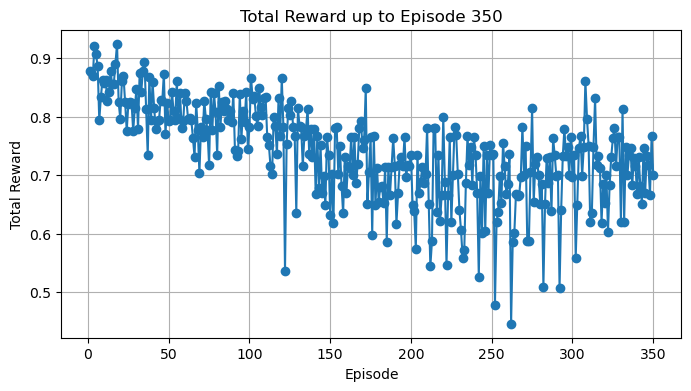

Episode 350 | Total Reward: 0.70 | Total Fitness: 0.85 | Total Distance: 2823.54 | Total Time: 1620.81 | Total Success : 0.73 | Epsilon: 0.172
Episode 351 | Total Reward: 0.54 | Total Fitness: 0.77 | Total Distance: 2758.61 | Total Time: 1726.00 | Total Success : 0.57 | Epsilon: 0.171
Episode 352 | Total Reward: 0.72 | Total Fitness: 0.85 | Total Distance: 2701.83 | Total Time: 1657.02 | Total Success : 0.75 | Epsilon: 0.170
Episode 353 | Total Reward: 0.73 | Total Fitness: 0.85 | Total Distance: 2640.62 | Total Time: 1502.55 | Total Success : 0.77 | Epsilon: 0.170
Episode 354 | Total Reward: 0.70 | Total Fitness: 0.87 | Total Distance: 2781.35 | Total Time: 1762.04 | Total Success : 0.73 | Epsilon: 0.169
Episode 355 | Total Reward: 0.65 | Total Fitness: 0.93 | Total Distance: 2819.20 | Total Time: 1758.74 | Total Success : 0.68 | Epsilon: 0.168
Episode 356 | Total Reward: 0.71 | Total Fitness: 0.94 | Total Distance: 2645.71 | Total Time: 1698.51 | Total Success : 0.75 | Epsilon: 0.167

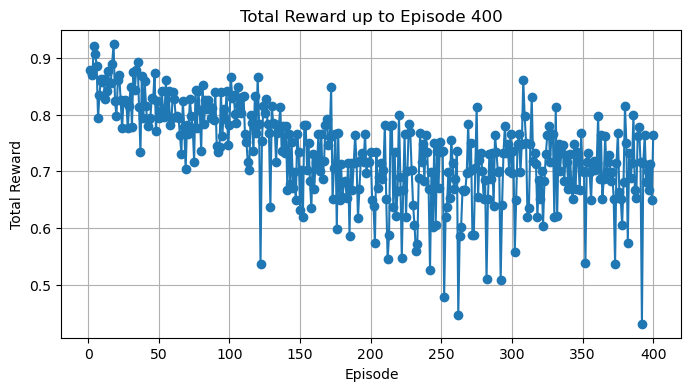

Episode 400 | Total Reward: 0.70 | Total Fitness: 0.90 | Total Distance: 2807.85 | Total Time: 1635.23 | Total Success : 0.73 | Epsilon: 0.134
Episode 401 | Total Reward: 0.69 | Total Fitness: 0.88 | Total Distance: 2601.03 | Total Time: 1589.57 | Total Success : 0.72 | Epsilon: 0.133
Episode 402 | Total Reward: 0.73 | Total Fitness: 0.90 | Total Distance: 2570.01 | Total Time: 1571.03 | Total Success : 0.77 | Epsilon: 0.133
Episode 403 | Total Reward: 0.65 | Total Fitness: 0.84 | Total Distance: 2746.65 | Total Time: 1620.13 | Total Success : 0.68 | Epsilon: 0.132
Episode 404 | Total Reward: 0.70 | Total Fitness: 0.88 | Total Distance: 2702.49 | Total Time: 1638.80 | Total Success : 0.73 | Epsilon: 0.131
Episode 405 | Total Reward: 0.70 | Total Fitness: 0.90 | Total Distance: 2862.26 | Total Time: 1648.46 | Total Success : 0.73 | Epsilon: 0.131
Episode 406 | Total Reward: 0.75 | Total Fitness: 0.90 | Total Distance: 2646.75 | Total Time: 1591.34 | Total Success : 0.78 | Epsilon: 0.130

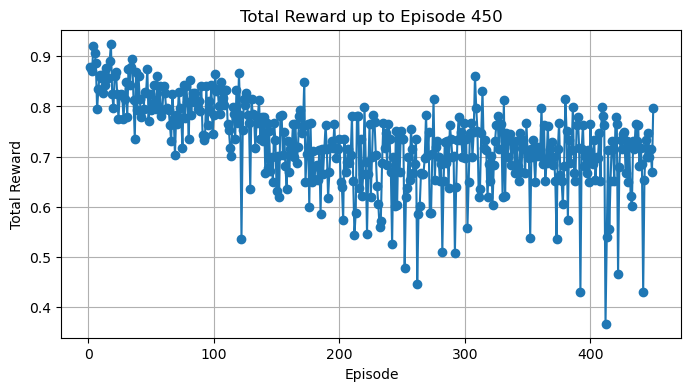

Episode 450 | Total Reward: 0.73 | Total Fitness: 0.88 | Total Distance: 2693.55 | Total Time: 1656.28 | Total Success : 0.77 | Epsilon: 0.104
Episode 451 | Total Reward: 0.56 | Total Fitness: 0.77 | Total Distance: 2569.74 | Total Time: 1843.83 | Total Success : 0.58 | Epsilon: 0.104
Episode 452 | Total Reward: 0.60 | Total Fitness: 0.86 | Total Distance: 2738.41 | Total Time: 1967.97 | Total Success : 0.63 | Epsilon: 0.103
Episode 453 | Total Reward: 0.75 | Total Fitness: 0.93 | Total Distance: 2685.48 | Total Time: 1625.66 | Total Success : 0.78 | Epsilon: 0.103
Episode 454 | Total Reward: 0.72 | Total Fitness: 0.89 | Total Distance: 2741.73 | Total Time: 1588.27 | Total Success : 0.75 | Epsilon: 0.102
Episode 455 | Total Reward: 0.70 | Total Fitness: 0.89 | Total Distance: 2784.93 | Total Time: 1607.27 | Total Success : 0.73 | Epsilon: 0.102
Episode 456 | Total Reward: 0.78 | Total Fitness: 0.90 | Total Distance: 2832.21 | Total Time: 1610.66 | Total Success : 0.82 | Epsilon: 0.101

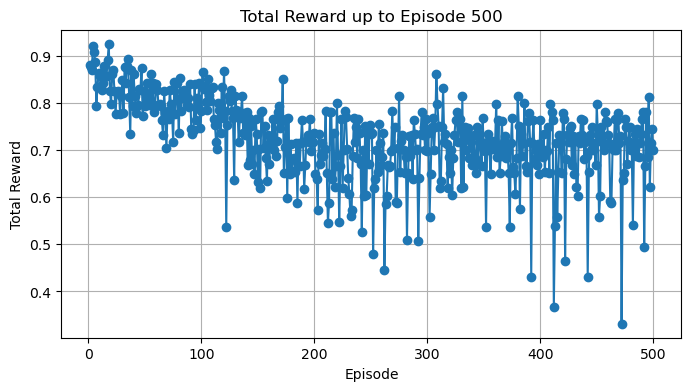

Episode 500 | Total Reward: 0.73 | Total Fitness: 0.93 | Total Distance: 2687.69 | Total Time: 1531.64 | Total Success : 0.77 | Epsilon: 0.081
Episode 501 | Total Reward: 0.65 | Total Fitness: 0.79 | Total Distance: 2661.43 | Total Time: 1537.63 | Total Success : 0.68 | Epsilon: 0.081
Episode 502 | Total Reward: 0.76 | Total Fitness: 0.93 | Total Distance: 2804.82 | Total Time: 1684.75 | Total Success : 0.80 | Epsilon: 0.080
Episode 503 | Total Reward: 0.73 | Total Fitness: 0.86 | Total Distance: 2779.91 | Total Time: 1528.29 | Total Success : 0.77 | Epsilon: 0.080
Episode 504 | Total Reward: 0.72 | Total Fitness: 0.91 | Total Distance: 2528.74 | Total Time: 1687.65 | Total Success : 0.75 | Epsilon: 0.080
Episode 505 | Total Reward: 0.71 | Total Fitness: 0.88 | Total Distance: 2688.65 | Total Time: 1564.47 | Total Success : 0.75 | Epsilon: 0.079
Episode 506 | Total Reward: 0.75 | Total Fitness: 0.93 | Total Distance: 2820.81 | Total Time: 1635.08 | Total Success : 0.78 | Epsilon: 0.079

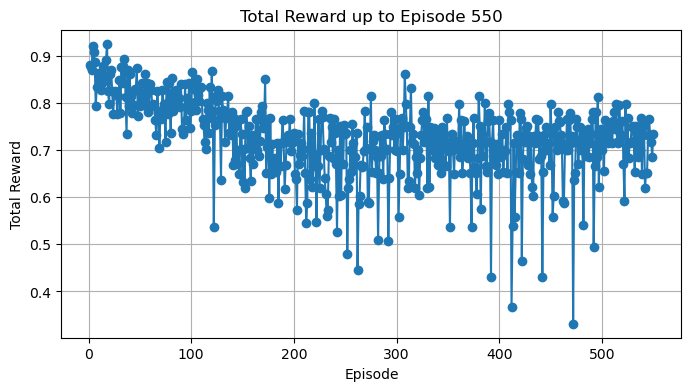

Episode 550 | Total Reward: 0.76 | Total Fitness: 0.95 | Total Distance: 2793.27 | Total Time: 1689.23 | Total Success : 0.80 | Epsilon: 0.063
Episode 551 | Total Reward: 0.78 | Total Fitness: 0.92 | Total Distance: 2754.54 | Total Time: 1632.96 | Total Success : 0.82 | Epsilon: 0.063
Episode 552 | Total Reward: 0.65 | Total Fitness: 0.80 | Total Distance: 2833.99 | Total Time: 1594.33 | Total Success : 0.68 | Epsilon: 0.063
Episode 553 | Total Reward: 0.77 | Total Fitness: 0.88 | Total Distance: 2711.34 | Total Time: 1497.68 | Total Success : 0.80 | Epsilon: 0.062
Episode 554 | Total Reward: 0.73 | Total Fitness: 0.92 | Total Distance: 2892.39 | Total Time: 1733.19 | Total Success : 0.77 | Epsilon: 0.062
Episode 555 | Total Reward: 0.65 | Total Fitness: 0.93 | Total Distance: 2784.37 | Total Time: 1557.83 | Total Success : 0.68 | Epsilon: 0.062
Episode 556 | Total Reward: 0.70 | Total Fitness: 0.90 | Total Distance: 2802.93 | Total Time: 1576.70 | Total Success : 0.73 | Epsilon: 0.061

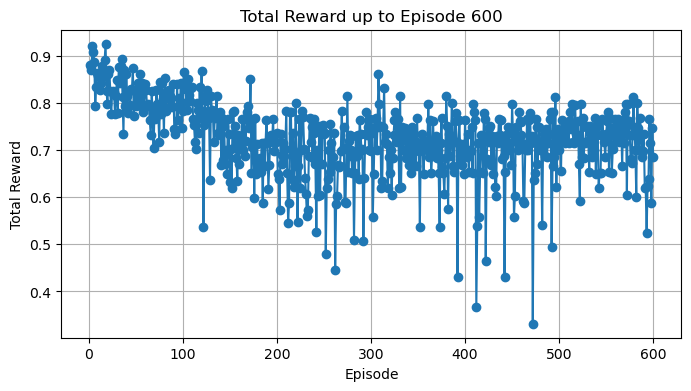

Episode 600 | Total Reward: 0.76 | Total Fitness: 0.88 | Total Distance: 2759.86 | Total Time: 1551.84 | Total Success : 0.80 | Epsilon: 0.049
Episode 601 | Total Reward: 0.57 | Total Fitness: 0.80 | Total Distance: 2966.44 | Total Time: 1736.22 | Total Success : 0.60 | Epsilon: 0.049
Episode 602 | Total Reward: 0.73 | Total Fitness: 0.85 | Total Distance: 2847.75 | Total Time: 1724.60 | Total Success : 0.77 | Epsilon: 0.049
Episode 603 | Total Reward: 0.60 | Total Fitness: 0.80 | Total Distance: 2576.64 | Total Time: 1749.75 | Total Success : 0.63 | Epsilon: 0.048
Episode 604 | Total Reward: 0.75 | Total Fitness: 0.91 | Total Distance: 2750.75 | Total Time: 1516.30 | Total Success : 0.78 | Epsilon: 0.048
Episode 605 | Total Reward: 0.70 | Total Fitness: 0.88 | Total Distance: 2668.38 | Total Time: 1610.02 | Total Success : 0.73 | Epsilon: 0.048
Episode 606 | Total Reward: 0.73 | Total Fitness: 0.85 | Total Distance: 2783.84 | Total Time: 1549.36 | Total Success : 0.77 | Epsilon: 0.048

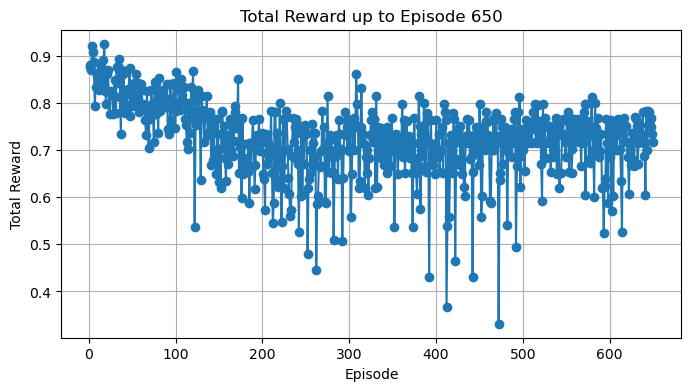

Episode 650 | Total Reward: 0.77 | Total Fitness: 0.90 | Total Distance: 2688.92 | Total Time: 1595.37 | Total Success : 0.80 | Epsilon: 0.038
Episode 651 | Total Reward: 0.76 | Total Fitness: 0.88 | Total Distance: 2721.71 | Total Time: 1568.27 | Total Success : 0.80 | Epsilon: 0.038
Episode 652 | Total Reward: 0.72 | Total Fitness: 0.90 | Total Distance: 2858.16 | Total Time: 1636.96 | Total Success : 0.75 | Epsilon: 0.038
Episode 653 | Total Reward: 0.63 | Total Fitness: 0.86 | Total Distance: 2745.36 | Total Time: 1736.16 | Total Success : 0.67 | Epsilon: 0.038
Episode 654 | Total Reward: 0.76 | Total Fitness: 0.93 | Total Distance: 2665.83 | Total Time: 1653.39 | Total Success : 0.80 | Epsilon: 0.038
Episode 655 | Total Reward: 0.68 | Total Fitness: 0.90 | Total Distance: 2728.69 | Total Time: 1652.94 | Total Success : 0.72 | Epsilon: 0.037
Episode 656 | Total Reward: 0.75 | Total Fitness: 0.90 | Total Distance: 2805.62 | Total Time: 1611.58 | Total Success : 0.78 | Epsilon: 0.037

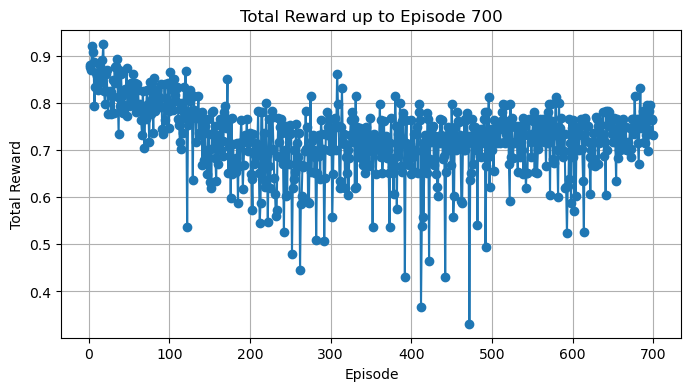

Episode 700 | Total Reward: 0.76 | Total Fitness: 0.94 | Total Distance: 2778.41 | Total Time: 1675.95 | Total Success : 0.80 | Epsilon: 0.030
Episode 701 | Total Reward: 0.78 | Total Fitness: 0.90 | Total Distance: 2677.60 | Total Time: 1490.03 | Total Success : 0.82 | Epsilon: 0.030
Episode 702 | Total Reward: 0.80 | Total Fitness: 0.90 | Total Distance: 2799.95 | Total Time: 1595.70 | Total Success : 0.83 | Epsilon: 0.029
Episode 703 | Total Reward: 0.80 | Total Fitness: 0.93 | Total Distance: 2826.85 | Total Time: 1646.33 | Total Success : 0.83 | Epsilon: 0.029
Episode 704 | Total Reward: 0.78 | Total Fitness: 0.90 | Total Distance: 2727.92 | Total Time: 1595.38 | Total Success : 0.82 | Epsilon: 0.029
Episode 705 | Total Reward: 0.70 | Total Fitness: 0.89 | Total Distance: 2883.85 | Total Time: 1618.66 | Total Success : 0.73 | Epsilon: 0.029
Episode 706 | Total Reward: 0.77 | Total Fitness: 0.94 | Total Distance: 2740.03 | Total Time: 1570.30 | Total Success : 0.80 | Epsilon: 0.029

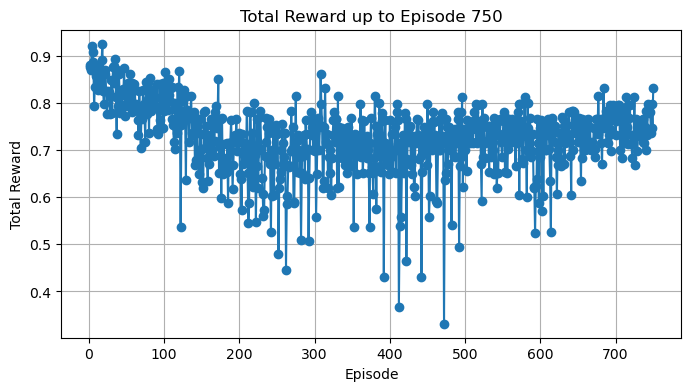

Episode 750 | Total Reward: 0.81 | Total Fitness: 0.92 | Total Distance: 2724.72 | Total Time: 1596.15 | Total Success : 0.85 | Epsilon: 0.023
Episode 751 | Total Reward: 0.67 | Total Fitness: 0.87 | Total Distance: 2863.72 | Total Time: 1796.53 | Total Success : 0.70 | Epsilon: 0.023
Episode 752 | Total Reward: 0.76 | Total Fitness: 0.92 | Total Distance: 2822.68 | Total Time: 1690.37 | Total Success : 0.80 | Epsilon: 0.023
Episode 753 | Total Reward: 0.73 | Total Fitness: 0.90 | Total Distance: 2778.86 | Total Time: 1666.75 | Total Success : 0.77 | Epsilon: 0.023
Episode 754 | Total Reward: 0.76 | Total Fitness: 0.88 | Total Distance: 2771.45 | Total Time: 1624.71 | Total Success : 0.80 | Epsilon: 0.023
Episode 755 | Total Reward: 0.73 | Total Fitness: 0.91 | Total Distance: 2742.91 | Total Time: 1500.16 | Total Success : 0.77 | Epsilon: 0.023
Episode 756 | Total Reward: 0.75 | Total Fitness: 0.89 | Total Distance: 2818.78 | Total Time: 1559.55 | Total Success : 0.78 | Epsilon: 0.022

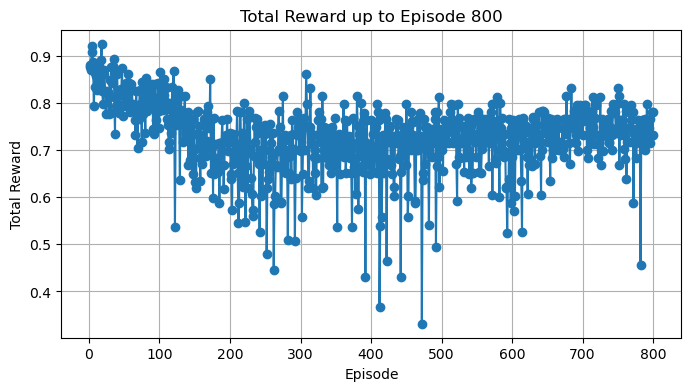

In [39]:
"""
运行 myDQN 优化
"""
from train.dqn_train import train_dqn
model = train_dqn(env, model_name="my_dqn_model.pth")

In [40]:
"""
运行 GA 优化
"""
# from model.ga import GeneticAlgorithmScheduler
# ga_scheduler = GeneticAlgorithmScheduler(env)
# best_solution, best_fitness = ga_scheduler.run()

'\n运行 GA 优化\n'

In [41]:
"""
运行 PSO 优化
"""
# from model.pso import PSO
# pso = PSO(env, num_particles=30, max_iter=100)
# best_position, best_fitness = pso.optimize()

'\n运行 PSO 优化\n'

In [42]:
"""
运行 HS_MOPSO 优化
"""
# from model.hs_mopso import HS_MOPSO
# mopso = HS_MOPSO(env, max_iter=80, pop_size=120)
# mopso.run()

'\n运行 HS_MOPSO 优化\n'

In [43]:
"""
运行 RR 轮询算法
"""
# from model.rr import round_robin_allocation
# round_robin_allocation(env)

'\n运行 RR 轮询算法\n'

In [44]:
"""
运行随机算法
"""
# from model.random import random_allocation
# random_allocation(env)

'\n运行随机算法\n'